Uncomment the following lines if running on Google Colaboratory. This will install versions of PyTorch and CuPy that work with our package, and then download the package files from the GitHub repo.

Restart the runtime when prompted to in the output of the cell.

In [1]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cupy-cuda11x
# !git clone https://github.com/BouazzaSE/NeuralXVA
# !mv NeuralXVA/* ./
# !rm -R NeuralXVA

In [2]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from learning.cva_estimator_portfolio_int import CVAEstimatorPortfolioInt
from learning.ec_estimator_portfolio import ECEstimatorPortfolio
from learning.fva_onestep_estimator_portfolio import FVAOneStepEstimatorPortfolio
from learning.kva_onestep_estimator_portfolio import KVAOneStepEstimatorPortfolio
from learning.var_to_es_transform import VaRtoESTransform
from learning.misc import batch_mean
from simulation.diffusion_engine import DiffusionEngine
import time
import torch
import matplotlib as mpl

In [3]:
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumbaPerformanceWarning)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [7]:
def predict(estimator, num_coarse_steps, num_defs_per_path, num_paths, stop_at=0):
    features_gen = estimator._features_generator()
    predictor = estimator.predict(features_gen=features_gen, as_cuda_array=True, flatten=False)
    predicted_xva = np.empty((num_coarse_steps+1, num_defs_per_path*num_paths), dtype=np.float32)
    _v = predicted_xva.reshape(num_coarse_steps+1, num_defs_per_path, num_paths)
    for t in range(num_coarse_steps, stop_at-1, -1):
        next(predictor)
        _v[t] = predictor.send(t)
    return predicted_xva

In [8]:
def predict_only_stats(estimator, stats, num_coarse_steps, num_defs_per_path, num_paths, recompute_at_zero=False):
    for stat in stats:
        assert isinstance(stat, str) or isinstance(stat, tuple)
        assert stat=='mean' or stat=='std' or ((len(stat)==2) and stat[0]=='quantile')
    predictor = estimator.predict(as_cuda_array=True, flatten=False)
    predicted_xva_stats = {stat: np.empty(num_coarse_steps+1, dtype=np.float32) for stat in stats}
    end = 0 if recompute_at_zero else -1
    for t in range(num_coarse_steps, end, -1):
        next(predictor)
        _v = torch.as_tensor(predictor.send(t), dtype=torch.float32, device=device).view(-1)
        for stat, predicted_xva_stat in predicted_xva_stats.items():
            if stat == 'mean':
                _stat = _v.mean().item()
            elif stat == 'std':
                _stat = _v.std().item()
            else:
                _stat = _v.quantile(stat[1]).item()
            predicted_xva_stat[t] = _stat
    if recompute_at_zero:
        batch_gen = estimator._batch_generator(labels_as_cuda_tensors=True, train_mode=False)
        for t, features_gen, labels_gen in batch_gen:
            if t == 0:
                if estimator._estimator.regr_type in ('mean', 'positive_mean'):
                    estimator.saved_states[0] = (False, batch_mean(labels_gen()).item())
                elif estimator._estimator.regr_type == 'quantile':
                    estimator.saved_states[0] = (False, torch.quantile(torch.cat(list(labels_gen()), dim=0), 1-estimator.quantile_level).item())
                else:
                    raise NotImplementedError
                for stat, predicted_xva_stat in predicted_xva_stats.items():
                    predicted_xva_stat[0] = 0 if stat=='std' else estimator.saved_states[0][1]
                break
    return predicted_xva_stats

In [46]:
def compute_twin_l2_err(estimator, end=0):
    estimator.diffusion_engine.generate_batch(fused=True, set_irs_at_par=False)
    predictor = estimator.predict(as_cuda_array=True, flatten=False)
    labels_gen = estimator._build_labels(True, load_from_device=False)
    labels_twin_gen = estimator._build_labels(True, load_from_device=True)
    _err_estimates = np.empty(estimator.diffusion_engine.num_coarse_steps+1, dtype=np.float32)
    _err_estimates_coarse = np.empty(estimator.diffusion_engine.num_coarse_steps+1, dtype=np.float32)
    _err_estimates_non_norm = np.empty(estimator.diffusion_engine.num_coarse_steps+1, dtype=np.float32)
    _err_estimates_coarse_non_norm = np.empty(estimator.diffusion_engine.num_coarse_steps+1, dtype=np.float32)
    _mean_labels = np.empty(estimator.diffusion_engine.num_coarse_steps+1, dtype=np.float32)
    mean_labels = _mean_labels
    for t in range(estimator.diffusion_engine.num_coarse_steps, end-1, -1):
        estimator.diffusion_engine.single_step_diffuse_and_price(t)
        next(predictor)
        f = torch.as_tensor(predictor.send(t), device=device).view(-1, 1)
        y_0 = next(labels_gen)
        y_1 = next(labels_twin_gen)
        _err_estimates_coarse_non_norm[t] = ((f-y_0)**2).mean().sqrt().item()
        _err_estimates_non_norm[t] = (f**2-(y_0+y_1)*f+y_0*y_1).mean().sqrt().item()
        norm = ((y_0*y_1).mean()+1e-7).sqrt().item()
        _err_estimates_coarse[t] = _err_estimates_coarse_non_norm[t]/norm
        _err_estimates[t] = _err_estimates_non_norm[t]/norm
        _mean_labels[t] = y_0.mean()
    return _err_estimates, _err_estimates_coarse, _err_estimates_non_norm, _err_estimates_coarse_non_norm

## Simulation parameters

* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in \[1\]);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in \[1\]);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of \[1\]:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

**\[1\]** Abbas-Turki, L., S. Crépey, and B. Saadeddine (2022). Hierarchical simulation for learning with defaults. Pre-print available on https://perso.lpsm.paris/~crepey/papers/LEARNING_FROM_DEFAULTS.pdf.

In [10]:
horizon = 10
num_fine_steps = 4096
dt = horizon/num_fine_steps
num_fine_per_coarse = 4 # 8, 16, 32, 64, 128
dT = num_fine_per_coarse*dt
num_coarse_steps = num_fine_steps//num_fine_per_coarse
num_paths = 2**14
num_inner_paths = 1
num_defs_per_path = 128 #256
num_rates = 10
num_spreads = 9
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.4, 0.03, num_rates)
rates_params['b'] = np.random.normal(0.03, 0.001, num_rates)
rates_params['sigma'] = np.abs(np.random.normal(0.0025, 0.00025, num_rates))
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.25, 0.025, num_rates-1))
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameters
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.5, 0.03, num_spreads)
spreads_params['b'] = np.random.normal(0.01, 0.001, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.0075, 0.00075, num_spreads))
initial_values[2*num_rates-1:] = 0.01

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 64 # 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0
vanilla_specs = np.empty(num_vanillas,
                         dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])

num_irs = 100 # 500
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 128*dt # 0.2  # Reset frequency
irs_specs['notional'] = 10000. * \
    ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5)))
     * np.random.choice(range(1, 11), num_irs))  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs))  # Swap rate
irs_specs['num_resets'] = np.random.randint(int((1+dt)/(128*dt)), num_fine_steps//128+1, num_irs, np.int32)  # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates-1, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs, 
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

Next, we select the GPU. Should be `cuda:0` if there is only one GPU available. This is where both the simulation and the training/inference are going to be performed.

In [11]:
device = torch.device('cuda:0')

We then instantiate the diffusion engine and the estimators (one with default indicators and the other with default intensities).

In [12]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device.index, 
                                   no_nested_cva=True, no_nested_im=True)

Successfully compiled all kernels.


In [13]:
with torch.cuda.device(device):
    _evt_start = torch.cuda.Event(enable_timing=True)
    _evt_stop = torch.cuda.Event(enable_timing=True)

In [14]:
_evt_start.record()
diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Everything done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 9172.236 ms
Everything done in 11181.678 ms


In [15]:
X = diffusion_engine.X
mtm_by_cpty = diffusion_engine.mtm_by_cpty
cash_flows_by_cpty = diffusion_engine.cash_flows_by_cpty
cash_pos_by_cpty = diffusion_engine.cash_pos_by_cpty
spread_integrals = diffusion_engine.spread_integrals
dom_rate_integral = diffusion_engine.dom_rate_integral
def_indicators = diffusion_engine.def_indicators

In [16]:
cva_estimators = {}
var_ec_estimators = {}
es_ec_estimators = {}
kva_estimators = {}
fva_estimators = {}

i = 3 # normally we'd loop over multiple values of i to have different learners for different time-steps, but let's assume the time-step is fixed here so that we get some results faster
print('[USING dT={}]'.format(dT*2**i))
_diffusion_engine = None
_diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps//2**i, dT*2**i, num_fine_per_coarse*2**i, dt,
                                    num_paths, num_inner_paths, num_defs_per_path, 
                                    num_rates, num_spreads, R, rates_params, fx_params, 
                                    spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                    initial_values, initial_defaults, cDtoH_freq, device.index, 
                                    no_nested_cva=True, no_nested_im=True)
_diffusion_engine.X[:] = X[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.mtm_by_cpty[:] = mtm_by_cpty[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.cash_flows_by_cpty[:] = cash_flows_by_cpty[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.cash_pos_by_cpty[:] = cash_pos_by_cpty[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.spread_integrals[:] = spread_integrals[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.dom_rate_integral[:] = dom_rate_integral[range(0, num_coarse_steps+1, 2**i)]
_diffusion_engine.def_indicators[:] = def_indicators[range(0, num_coarse_steps+1, 2**i)]
num_steps_per_reset = int((irs_specs['reset_freq'][0]+dt)/(dT*2**i))
prev_reset_arr = (np.arange(num_coarse_steps//2**i+1)-1)//num_steps_per_reset*num_steps_per_reset
cva_estimators[dT*2**i] = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, _diffusion_engine, 
                                                   device, 1, 2*(num_rates+num_spreads), 
                                                   (num_paths*num_defs_per_path)//8, 
                                                   16, 0.01, 0, reset_weights=False, linear=False, 
                                                   best_sol=True, refine_last_layer=True)
print('* Training CVA')
_evt_start.record()
batch_gen = cva_estimators[dT*2**i]._batch_generator(labels_as_cuda_tensors=True, train_mode=True)
for _ in cva_estimators[dT*2**i]._train(batch_gen, None):
    print('.', end='')
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('\ndone in {} secs'.format(round(elapsed_time_def, 2)))
var_ec_estimators[dT*2**i] = ECEstimatorPortfolio(torch.as_tensor(0.025, dtype=torch.float32, device=device), 
                                             128//2**i, [cva_estimators[dT*2**i]], prev_reset_arr, True, False, False, 
                                             _diffusion_engine, device, 1, 2*(num_rates+num_spreads), 
                                             (num_paths*num_defs_per_path)//8, 16, 1e-3, 0, 
                                             reset_weights=False, linear=False, best_sol=True, 
                                             refine_last_layer=True)
es_ec_estimators[dT*2**i] = VaRtoESTransform(var_ec_estimators[dT*2**i], prev_reset_arr, True, False, False, 
                                             _diffusion_engine, device, 1, 2*(num_rates+num_spreads), 
                                             (num_paths*num_defs_per_path)//8, 16, 0.01, 0, 
                                             reset_weights=False, linear=False, best_sol=True, 
                                             refine_last_layer=True)
kva_estimators[dT*2**i] = KVAOneStepEstimatorPortfolio(0.12, es_ec_estimators[dT*2**i],
                                                      prev_reset_arr, True, False, False, _diffusion_engine, 
                                                      device, 1, 2*(num_rates+num_spreads), 
                                                      (num_paths*num_defs_per_path)//8, 
                                                      16, 0.01, 0, reset_weights=False, 
                                                      linear=False, best_sol=True, refine_last_layer=True)
fva_estimators[dT*2**i] = FVAOneStepEstimatorPortfolio([cva_estimators[dT*2**i]], 
                                                       var_ec_estimators[dT*2**i], es_ec_estimators[dT*2**i], 
                                                      kva_estimators[dT*2**i], prev_reset_arr, 
                                                      True, False, False, _diffusion_engine, 
                                                      device, 1, 2*(num_rates+num_spreads), 
                                                      (num_paths*num_defs_per_path)//8, 
                                                      16, 0.01, 0, reset_weights=False, 
                                                      linear=False, best_sol=True, refine_last_layer=True)
var_ec_estimators[dT*2**i].xva_terms.append(fva_estimators[dT*2**i])
print('* Training FVA...', end='')
_evt_start.record()
fva_estimators[dT*2**i].train(labels_as_cuda_tensors=True, measure_exec_times=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

[USING dT=0.078125]
Successfully compiled all kernels.
* Training CVA
.................................................................................................................................
done in 133.86 secs
* Training FVA...done in 596.19 secs


In [17]:
stats = ('mean', ('quantile', 0.99), ('quantile', 0.975), ('quantile', 0.025), ('quantile', 0.01))

predicted_cva_stats = {}
predicted_fva_stats = {}

i = 3
print('[ dT={} ]'.format(dT*2**i))
print('* Performing inference for CVA...', end='')
_chrono_start = time.time()
predicted_cva_stats[dT*2**i] = predict_only_stats(cva_estimators[dT*2**i], stats, num_coarse_steps//2**i, num_defs_per_path, num_paths, recompute_at_zero=False)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))
print('* Performing inference for FVA...', end='')
_chrono_start = time.time()
predicted_fva_stats[dT*2**i] = predict_only_stats(fva_estimators[dT*2**i], stats, num_coarse_steps//2**i, num_defs_per_path, num_paths, recompute_at_zero=False)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

[ dT=0.078125 ]
* Performing inference for CVA...done in 3.3 secs
* Performing inference for FVA...done in 3.29 secs


In [18]:
stats = ('mean', ('quantile', 0.99), ('quantile', 0.975), ('quantile', 0.025), ('quantile', 0.01))

predicted_var_ec_stats = {}
predicted_es_ec_stats = {}

i = 3
print('[ dT={} ]'.format(dT*2**i))
print('* Performing inference for EC...', end='')
_chrono_start = time.time()
predicted_var_ec_stats[dT*2**i] = predict_only_stats(var_ec_estimators[dT*2**i], stats, num_coarse_steps//2**i, num_defs_per_path, num_paths, recompute_at_zero=True)
predicted_es_ec_stats[dT*2**i] = predict_only_stats(es_ec_estimators[dT*2**i], stats, num_coarse_steps//2**i, num_defs_per_path, num_paths, recompute_at_zero=True)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

[ dT=0.078125 ]
* Performing inference for EC...done in 68.95 secs


In [19]:
stats = ('mean', ('quantile', 0.99), ('quantile', 0.975), ('quantile', 0.025), ('quantile', 0.01))

predicted_kva_stats = {}

i = 3
print('[ dT={} ]'.format(dT*2**i))
print('* Performing inference for KVA...', end='')
_chrono_start = time.time()
predicted_kva_stats[dT*2**i] = predict_only_stats(kva_estimators[dT*2**i], stats, num_coarse_steps//2**i, num_defs_per_path, num_paths, recompute_at_zero=True)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

[ dT=0.078125 ]
* Performing inference for KVA...done in 8.29 secs


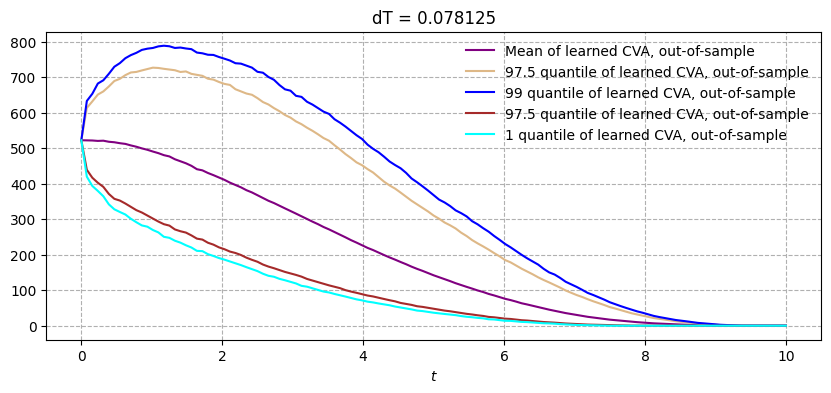

In [23]:
i = 3

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_cva_stats[dT*2**i]['mean'], label='Mean of learned CVA, out-of-sample', color='purple')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_cva_stats[dT*2**i]['quantile', 0.975], label='97.5 quantile of learned CVA, out-of-sample', color='burlywood')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_cva_stats[dT*2**i]['quantile', 0.99], label='99 quantile of learned CVA, out-of-sample', color='blue')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_cva_stats[dT*2**i]['quantile', 0.025], label='97.5 quantile of learned CVA, out-of-sample', color='brown')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_cva_stats[dT*2**i]['quantile', 0.01], label='1 quantile of learned CVA, out-of-sample', color='cyan')
ax.grid(linestyle='--')
ax.set_xlabel('$t$')
ax.set_title(f'dT = {dT*2**i}')
plt.legend(loc='upper right', ncol=1, frameon=False);

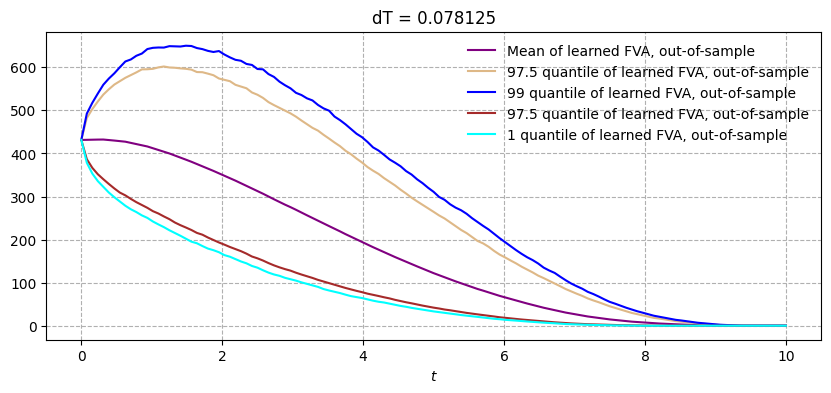

In [24]:
i = 3

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_fva_stats[dT*2**i]['mean'], label='Mean of learned FVA, out-of-sample', color='purple')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_fva_stats[dT*2**i]['quantile', 0.975], label='97.5 quantile of learned FVA, out-of-sample', color='burlywood')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_fva_stats[dT*2**i]['quantile', 0.99], label='99 quantile of learned FVA, out-of-sample', color='blue')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_fva_stats[dT*2**i]['quantile', 0.025], label='97.5 quantile of learned FVA, out-of-sample', color='brown')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_fva_stats[dT*2**i]['quantile', 0.01], label='1 quantile of learned FVA, out-of-sample', color='cyan')
ax.grid(linestyle='--')
ax.set_xlabel('$t$')
ax.set_title(f'dT = {dT*2**i}')
plt.legend(loc='upper right', ncol=1, frameon=False);

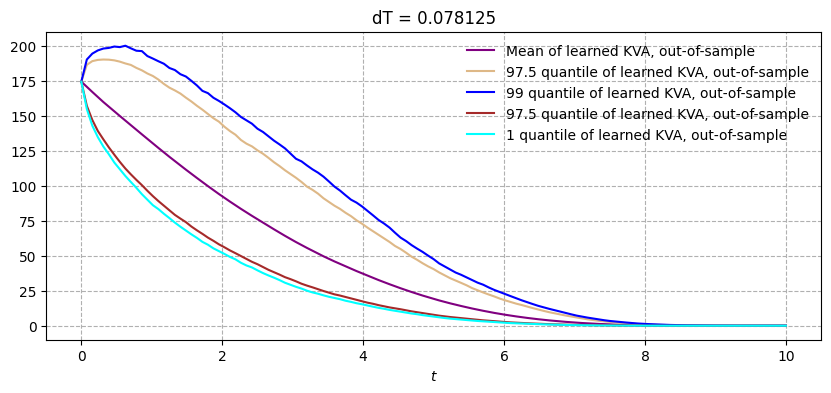

In [25]:
i = 3

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_kva_stats[dT*2**i]['mean'], label='Mean of learned KVA, out-of-sample', color='purple')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_kva_stats[dT*2**i]['quantile', 0.975], label='97.5 quantile of learned KVA, out-of-sample', color='burlywood')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_kva_stats[dT*2**i]['quantile', 0.99], label='99 quantile of learned KVA, out-of-sample', color='blue')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_kva_stats[dT*2**i]['quantile', 0.025], label='97.5 quantile of learned KVA, out-of-sample', color='brown')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_kva_stats[dT*2**i]['quantile', 0.01], label='1 quantile of learned KVA, out-of-sample', color='cyan')
ax.grid(linestyle='--')
ax.set_xlabel('$t$')
ax.set_title(f'dT = {dT*2**i}')
plt.legend(loc='upper right', ncol=1, frameon=False);

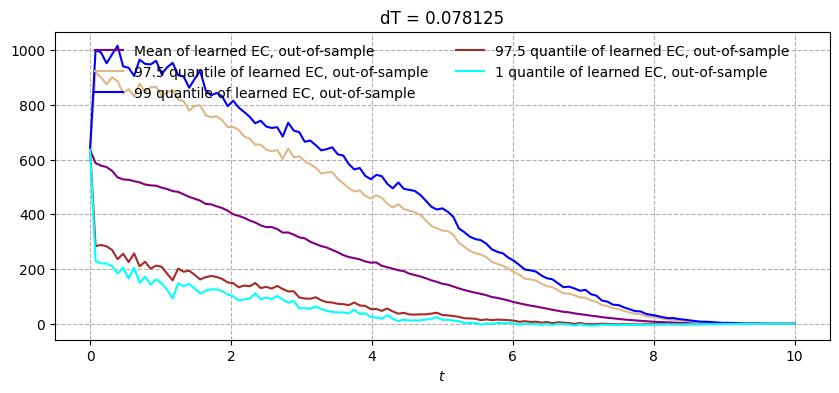

In [26]:
i = 3

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = plt.gca()
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_es_ec_stats[dT*2**i]['mean'], label='Mean of learned EC, out-of-sample', color='purple')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_es_ec_stats[dT*2**i]['quantile', 0.975], label='97.5 quantile of learned EC, out-of-sample', color='burlywood')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_es_ec_stats[dT*2**i]['quantile', 0.99], label='99 quantile of learned EC, out-of-sample', color='blue')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_es_ec_stats[dT*2**i]['quantile', 0.025], label='97.5 quantile of learned EC, out-of-sample', color='brown')
ax.plot(np.arange(0, num_coarse_steps+1, 2**i)*dT, predicted_es_ec_stats[dT*2**i]['quantile', 0.01], label='1 quantile of learned EC, out-of-sample', color='cyan')
ax.grid(linestyle='--')
ax.set_xlabel('$t$')
ax.set_title(f'dT = {dT*2**i}')
plt.legend(loc='upper center', ncol=2, frameon=False)

In [47]:
print(f'* Computing error estimates for FVA... ')
_chrono_start = time.time()
i = 3
fva_err_estimates, fva_err_estimates_coarse, fva_err_estimates_non_norm, fva_err_estimates_coarse_non_norm = compute_twin_l2_err(fva_estimators[dT*2**i])
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

* Computing error estimates for FVA... 
cuda_diffuse_and_price elapsed time: 3001.562 ms
done in 26.96 secs


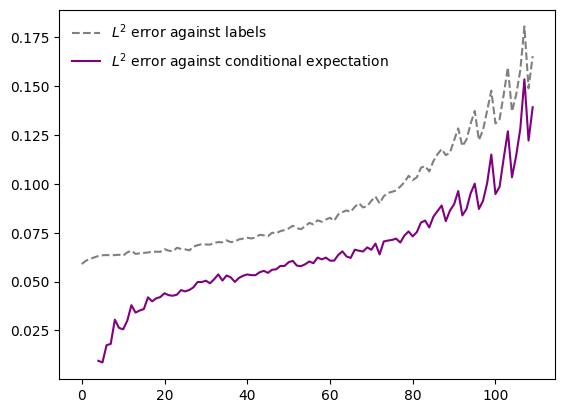

In [52]:
# not plotting beyond the index 110 as it's not informative because near maturity everything becomes almost deterministic and the denominator in the relative error grows big
plt.plot(fva_err_estimates_coarse[:110], label='$L^2$ error against labels', color='gray', linestyle='--')
plt.plot(fva_err_estimates[:110], label='$L^2$ error against conditional expectation', color='purple')
plt.legend(frameon=False)